In [101]:
%matplotlib inline

from collections import defaultdict
from collections import defaultdict
import scipy
import traceback
import os
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
import sys
import seaborn as sns; sns.set()  # for plot styling

import sklearn.cluster
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


import sklearn.cluster
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import mixture

#LOAD DATA
s = [6,8,10,13]
D = []

for i in range(4):
    input_path = 'filtered_gene_bc_matrices/10x/'+str(s[i])+'hpf-WT/'

    if os.path.isfile(input_path + '/matrix.npz'):
        E = scipy.sparse.load_npz(input_path + '/matrix.npz')
    else:
        E = scipy.io.mmread(input_path + '/matrix.mtx').T.tocsc()
        scipy.sparse.save_npz(input_path + '/matrix.npz', E, compressed=True)
    gene_list = np.array(load_genes(input_path + 'genes.tsv',column = 1))
    gene_id = np.array(load_genes(input_path + 'genes.tsv',column = 0))
    D.append(E)

    
D
#print(counts_list.shape)
#print('Matrix shape:'+str(E.shape))
#print('Genelist size:'+str(len(gene_list)))

[<901x25260 sparse matrix of type '<class 'numpy.int64'>'
 	with 2313753 stored elements in Compressed Sparse Column format>,
 <1556x25260 sparse matrix of type '<class 'numpy.int64'>'
 	with 3156153 stored elements in Compressed Sparse Column format>,
 <1435x25260 sparse matrix of type '<class 'numpy.int64'>'
 	with 2521205 stored elements in Compressed Sparse Column format>,
 <1640x25260 sparse matrix of type '<class 'numpy.int64'>'
 	with 3922937 stored elements in Compressed Sparse Column format>]

In [102]:
def master(E,m,umi1,umi2,gene1,gene2):
    Efilttemp1 = mito_frac(E,m)
    Efiltemp2 = threshold(Efilttemp1[0],umi1,umi2)
    Efiltemp3= GeneCount(Efiltemp2[0],gene1,gene2)
    Efiltemp3[0].shape
    E = Efiltemp3[0]
    
    ind = topgene(E,30)
    
    genenametemp = np.zeros(len(Efiltemp3[1])).astype(object)
    geneidstemp = np.zeros(len(Efiltemp3[1])).astype(object)
    k = 0
    for i in enumerate(Efiltemp3[1].flatten()):
        genenametemp[k] = gene_list[i[1]]
        geneidstemp[k] = gene_id[i[1]]
        k = k + 1    
    top_genes = genefetch(ind,genenametemp)
    
    print(top_genes)
    
    E = logtransform(E)
    
    X = E
    #X = StandardScaler().fit_transform(X)

    pca = PCA(n_components=20)
    pca.fit(X)
    X_pca = pca.transform(X)
    print("original shape:   ", X.shape)
    print("transformed shape:", X_pca.shape)
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(X_pca)
    y_kmeans = kmeans.predict(X_pca)
    fig = plt.figure()
    #X1 = np.tan(X_pca[:, 0])/np.mean(X_pca[:, 0])
    #X2 = np.tan(X_pca[:, 1])/np.mean(X_pca[:, 1])
    print("PCA 20 PC0 PC1")
    plt.scatter(X_pca[:, 0], X_pca[:, 1],marker='.', alpha=0.8,c=y_kmeans, cmap='viridis')
    plt.title("PCA1 PCA2")
    
    #np.array()
#     gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(X_pca[:,0],X_pca[:, 1])
#     colormap = gmm.predict(X_pca[:,0],X_pca[:, 1])
    fig2 = plt.figure()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X_pca)
    plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.6,c=y_kmeans, cmap='viridis',marker='.')
    plt.title("tsne")
        
    
#print (genenametemp.shape)
#print (geneidstemp.shape)
#genename6WTfilt = genenametemp
#geneids6WTfilt = geneidstemp
    

In [133]:
#Helper Functions

#Loading files

def load_genes(filename, delimiter='\t', column=0, skip_rows=0):
    gene_list = []
    gene_dict = {}

    with open(filename) as f:
        for iL in range(skip_rows):
            f.readline()
        for l in f:
            gene = l.strip('\n').split(delimiter)[column]
            gene = gene.replace("/", "\/")
            if gene in gene_dict:
                gene_dict[gene] += 1
                gene_list.append(gene + '__' + str(gene_dict[gene]))
                if gene_dict[gene] == 2:
                    i = gene_list.index(gene)
                    gene_list[i] = gene + '__1'
            else: 
                gene_dict[gene] = 1
                gene_list.append(gene)
    return gene_list

def load_text(file_data,delim='\t'):
    X_data = []
    X_row = []
    X_col = []

    start_column = -1
    start_row = -1
    for row_ix, dat in enumerate(file_data):
        dat = dat.strip('\n').split(delim)

        if start_row == -1:
            current_col = 0
            found_float = False
            while not found_float and current_col < len(dat):
                try: 
                    tmp = float(dat[current_col])
                    
                    try:
                        rowdat = np.array(map(float, dat[current_col:]))
                        ncol = len(rowdat)
                        col_ix = np.nonzero(rowdat)[0]

                        found_float = True
                        start_row = row_ix
                        start_column = current_col

                        X_col.extend(col_ix)
                        X_row.extend([row_ix - start_row] * len(col_ix))
                        X_data.extend(rowdat[col_ix])

                    except:
                        current_col += 1

                except:
                    current_col += 1
        else:
            try:
                rowdat = np.array(map(float, dat[start_column:]))
                if len(rowdat) != ncol:
                    return 'ERROR: Rows have different numbers of numeric columns.'
                col_ix = np.nonzero(rowdat)[0]
                X_col.extend(col_ix)
                X_row.extend([row_ix - start_row] * len(col_ix))
                X_data.extend(rowdat[col_ix])
            except:
                return 'ERROR: Rows have different numbers of numeric columns.'

    if start_row == -1:
        return 'ERROR: no numeric values found'

    nrow = row_ix - start_row + 1
    E = scipy.sparse.coo_matrix((X_data, (X_row, X_col)), dtype=float, shape=(nrow, ncol)).tocsc()
    
    return E

def file_opener(filename):
    fileData = open(filename)
    if filename.endswith('.gz'):
        import gzip
        outData = gzip.GzipFile(fileobj = fileData, mode = 'rb')
    elif filename.endswith('.zip'):
        import zipfile
        zipData = zipfile.ZipFile(fileData, 'r')
        fnClean = filename.strip('/').split('/')[-1][:-4]
        outData = zipData.open(fnClean)
    else:
        outData = fileData
    return outData

#Thresholding

def threshold(E,min_val,max_val):
    print('CellCount min:'+str(min_val)+' max:'+str(max_val))
    # plotting total counts pre-thresholding
    total_counts = np.sum(E, axis=1).A[:,0]
    tmpfilt = np.nonzero((total_counts <= max_val)&(total_counts >= min_val))[0]
    print('Pre-filter: %i barcodes' %E.shape[0])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(total_counts, bins=np.logspace(0, 6, 100))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    # applying filter
    Efilt = E[tmpfilt,:]
    print('Post-filter: %i barcodes' %Efilt.shape[0])
    total_counts_filt = np.sum(Efilt, axis=1).A[:,0]
    
    # plotting post filter
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(total_counts_filt, bins=np.logspace(0, 6, 100))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    return [Efilt,tmpfilt]

    
def GeneCount(E,min_val,max_val):
    print('GeneCount min:'+str(min_val)+' max:'+str(max_val))
    # plotting total counts pre-thresholding
    total_counts = np.sum(E, axis=0).A[0,:]
    tmpfilt = np.nonzero((total_counts <= max_val)&(total_counts >= min_val))[0]
    print('Pre-filter: %i barcodes' %E.shape[1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(total_counts, bins=np.logspace(0, 6, 50))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    # applying filter
    Efilt = E[:,tmpfilt]
    print('Post-filter: %i barcodes' %Efilt.shape[1])
    total_counts_filt = np.sum(Efilt, axis=0).A[0,:]
    
    # plotting post filter
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(total_counts_filt, bins=np.logspace(0, 6, 50))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    return [Efilt,tmpfilt]

def mito_frac(E,max_mt):
    #max_mt = 0.05
    print('Mito fraction filter: '+str(max_mt))
    
    #plotting the initial mito fraction
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, xscale='linear', yscale='linear',
        xlabel='MT frac.', ylabel='no. cells')
    mito_frac = np.sum(E[:,mt_ix], axis=1).A[:,0] / np.sum(E, axis=1,dtype=float).A[:,0]
    ax.hist(mito_frac, cumulative=False, 
            bins=np.linspace(0, 0.1, 100))

    #setting up filter
    tmpfilt = np.nonzero(mito_frac <= max_mt)[0]
    ax.plot([max_mt,max_mt],ax.get_ylim());
    print('Pre-filter: %i barcodes' %E.shape[0])
    Efilt = E[tmpfilt,:]
    print('Post-filter: %i barcodes' %Efilt.shape[0])
    
    #plotting post filter mito fraction
    total_counts_filt = mito_frac[tmpfilt]
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.hist(total_counts_filt, bins=np.linspace(0, 0.1, 100))

    return [Efilt,tmpfilt]

def logtransform(E):
    X = E.toarray()
    colsum = np.sum(X,axis=1)
    X = X/colsum[:,None]
    X1 = np.log(X+1)
    sumcol = np.mean(E, axis=0)
    X = X1-sumcol
    return X

### MITO FRACTION ###

mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('mt-')]
list1 = [gene_list[i] for i in mt_ix]
#print(mt_ix)

def contributor(E, cont):
    p1 = np.fabs(E)
    cont = cont*-1
    ind = np.argpartition(p1,cont)[cont:]
    return ind

def topgene(E,cont):
    X = E.toarray()
    X = np.log10(X+1)
    colsum = np.sum(X,axis=1)
    print(colsum.shape)
    X = X/colsum[:,None]
    colvar = np.var(X,axis=0)
    colmean = np.mean(X, axis=0)
    normvar = colvar/colmean
    print(normvar.shape)
    fig = plt.figure()
    sqnorm = np.sqrt(colvar)
    plt.scatter(np.log10(colmean),np.log10(normvar),marker='.')
#     ax = plt.gca()
#     ax.set_xscale('log')
    ind = contributor(normvar,cont)
    
    return ind
    
def genefetch(L,genelist):
    return genelist[L]
    

In [134]:
np.sum(E,axis=0).shape


(1, 25260)

(1640,)
(25260,)


C:\Users\Sanjit Dasgupta\Anaconda3.0\lib\site-packages\ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Sanjit Dasgupta\Anaconda3.0\lib\site-packages\ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in log10


array(['si:ch211-106k21.5', 'si:dkey-58b18.6', 'si:dkey-58b18.10__3',
       'si:dkey-58b18.2', 'BX677666.1', 'si:dkey-58b18.10__1',
       'si:dkey-58b18.10__2', 'si:dkey-58b18.8', 'si:dkey-58b18.3',
       'si:dkey-24c2.7', 'BX470197.1', 'BX470197.2', 'si:ch211-14p21.3',
       'si:ch73-129a22.11__3', 'si:dkey-58b18.9', 'si:ch211-14p21.4',
       'ghsra', 'sez6b', 'VOPP1 (1 of many)', 'kcnh2a', 'fitm1',
       'si:dkey-149i17.7', 'si:dkey-149i17.9', 'si:dkey-149i17.8',
       'si:dkey-149i17.11', 'ckmb', 'agtr1a', 'si:dkey-182i3.11',
       'si:dkey-223d7.6', 'ftr57'], dtype='<U25')

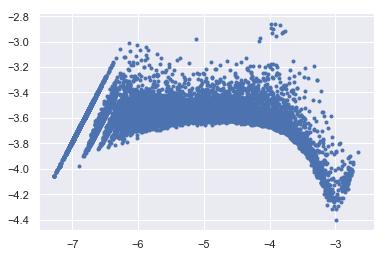

In [135]:
genefetch(topgene(E,30),gene_list)


In [48]:
E0 = D[0]
E1 = D[1]
E2 = D[2]
E3 = D[3]

Mito fraction filter: 0.04
Pre-filter: 901 barcodes
Post-filter: 887 barcodes
CellCount min:0 max:20000
Pre-filter: 887 barcodes
Post-filter: 873 barcodes
GeneCount min:100 max:5000
Pre-filter: 25260 barcodes
Post-filter: 5343 barcodes
(873,)
['VPS37D' 'CABZ01041962.1' 'scaf11' 'srrt' 'arpc5lb' 'mtch2' 'six7'
 'alkbh4' 'purba' 'ppil3' 'rnf170' 'ccdc125' 'znf1128__2' 'CABZ01037298.1'
 'riok2' 'TMEM208' 'mad2l1' 'tia1l' 'furina' 'rell1' 'ube2l3b' 'znf1067'
 'zgc:153993' 'zgc:173705' 'smn1' 'BX572103.7' 'efs' 'rbm4.1' 'arih1l'
 'hnrpkl']
original shape:    (873, 5343)
transformed shape: (873, 20)
PCA 20 PC0 PC1
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 873 samples in 0.002s...
[t-SNE] Computed neighbors for 873 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 873 / 873
[t-SNE] Mean sigma: 0.002425
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.421440
[t-SNE] Error after 300 iterations: 1.069178


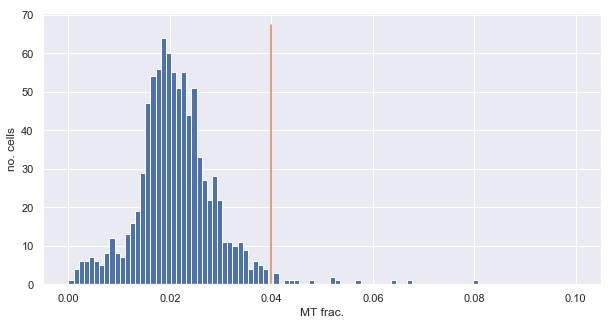

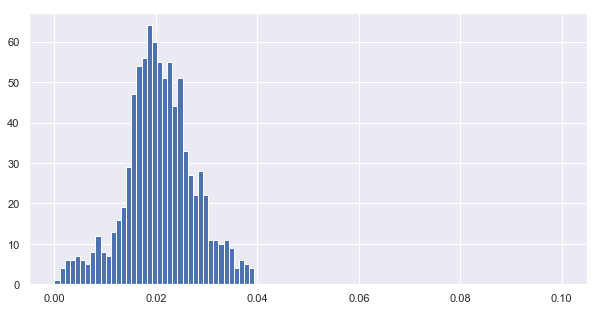

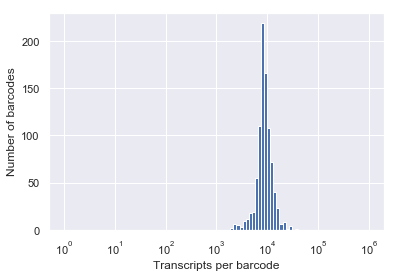

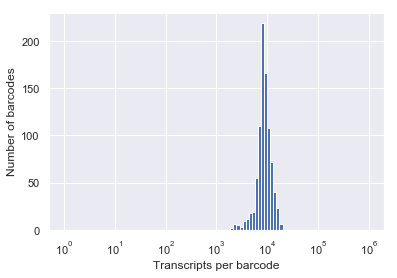

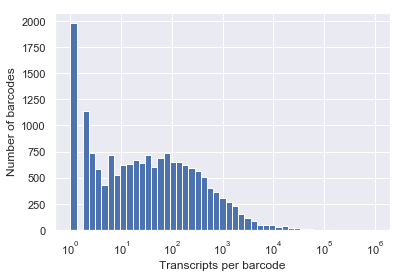

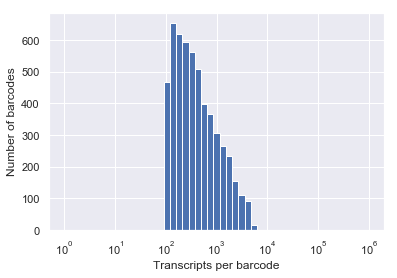

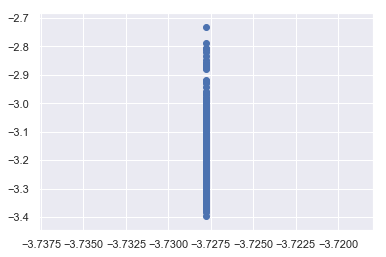

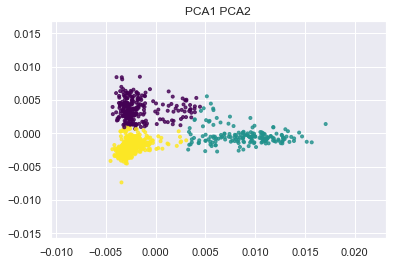

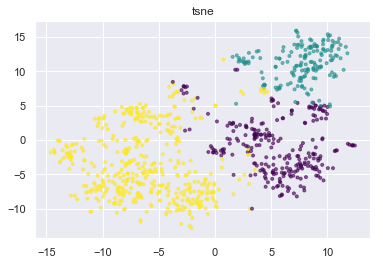

In [57]:
master(E0,0.04,0,20000,100,5000)

In [50]:
#master(E0,0.04,0,20000,100,5000)

In [51]:
#master(E1,0.04,0,20000,100,5000)

In [52]:
#master(E2,0.04,0,20000,100,5000)

In [53]:
#master(E3,0.04,0,20000,100,5000)